# Seoul Crime EDA

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
plt.style.use("ggplot")
from typing import List
import numpy as np

In [25]:
df = pd.read_csv("data/자치구별5대범죄/01-20_자치구별_5대범죄.csv")
assert df.year.dtype == int

df_quota = pd.read_csv(
    "./data/경찰청_경찰서별_경찰관현황/2014-2021_서울_경찰서별_정원.csv")
assert df_quota.ds.dtype == int

df_cctv = pd.read_csv(
    "data/서울시CCTV설치운영현황/서울시CCTV연도별신규설치수.csv",
    index_col=0,
)
df_cctv = df_cctv.drop("2012년 이전")
df_cctv["종로구"] = df_cctv["종로구"].fillna(-1).astype(int).replace(-1, pd.NA)
df_cctv.index = df_cctv.index.map(lambda x:  int(x[:4]))
df_cctv




,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,강북구,도봉구,...,강서구,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구
2012,<NA>,114,71,144,57,0,21,78,0,22,...,122,216,0,136,24,84,73,67,59,27
2013,<NA>,87,234,208,100,14,253,170,22,2,...,104,349,174,238,25,431,79,66,90,227
2014,195,77,125,107,187,16,72,229,61,145,...,202,187,80,123,503,439,70,580,85,49
2015,150,236,221,325,98,115,132,322,124,172,...,199,268,361,209,128,609,562,830,214,154
2016,0,240,298,255,52,804,155,594,251,123,...,168,326,133,248,253,622,504,1293,176,202
2017,261,372,351,967,675,814,153,890,29,129,...,506,540,196,311,271,688,1041,988,241,273
2018,85,386,125,415,465,201,174,867,391,222,...,259,488,539,658,300,674,417,745,541,377
2019,9,155,307,490,712,218,1049,714,1078,210,...,457,434,367,65,322,595,339,791,1073,356
2020,200,361,617,472,175,223,934,253,656,184,...,356,415,513,1213,419,331,433,926,235,614
2021,0,403,228,283,655,219,448,404,470,593,...,317,533,48,283,20,236,556,516,143,262


In [68]:
class CrimeAnalysis:
    def __init__(
        self,
        df: pd.DataFrame, 
        df_quota: pd.DataFrame, 
        df_cctv: pd.DataFrame, 
        quota_shift: int=3,
        cctv_shift: int=3,
    ) :
        # Merged with df_quota
        for shift in range(quota_shift):
            df[f"quota_{shift}"] = pd.NA
            for i, row in df.iterrows():
                year: int = row.year
                office: List[str] = eval(row.precinct)
                query = df_quota[(df_quota.ds == (year - shift))&(df_quota.officeName.isin(office))]
                if len(query) > 0 :
                    df[f"quota_{shift}"][i] = query.quota.sum()

        # Merged with df_cctv
        for shift in range(cctv_shift):
            df[f"cctv_{shift}"] = pd.NA
            for i, row in df[df.year >= 2012+shift].iterrows():
                df.loc[i, f"cctv_{shift}"] = df_cctv.loc[row.year - shift, row.gu]

        self.df: pd.DataFrame = df
        self.crimeNames: List[str] = self.df.crimeName.unique().tolist()
        self.colours: List[str] = ["red", "blue", "magenta", "navy", "purple"]
        

    def visualize(self, x: str, shift: List[int]=[0], occur=True, arrest=True):
        if type(shift) == int :
            shift = [shift]

        for i, crime in enumerate(self.crimeNames):
            fig, ax = plt.subplots(figsize=(15, 10))
            legend = []
            temp = self.df[(self.df.crimeName  == crime ) &(self.df.oa == "occur")  ]
            if occur:
                for j in shift:
                    XY = temp[[f"{x}_{j}", "crimeNum"]].dropna()
                    XY.columns = ["x", "y"]
                    ax.scatter(XY.x, XY.y, s=35, alpha=.9)
                    legend += [f"{crime}_발생수/{x}_{j}year_ago"] 

            if arrest:
                temp = self.df[(self.df.crimeName == crime ) & (self.df.oa == "arrest")]
                for j in shift:
                    XY = temp[[f"{x}_{j}", "crimeNum"]].dropna()
                    XY.columns = ["x", "y"]
                    ax.scatter(XY.x, XY.y,  s=35, alpha=.9, marker="x")
                    legend += [f"{crime}_검거수/{x}_{j}year_ago"]
            
            ax.legend(legend)
            ax.set_xlabel(x, fontsize=20)
            ax.set_title("   " + crime, fontsize=48, ha="left", va="center", loc="left")
            plt.show()

In [69]:
analysis = CrimeAnalysis(df, df_quota, df_cctv)

/tmp/ipykernel_1639/2180182837.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"quota_{shift}"][i] = query.quota.sum()


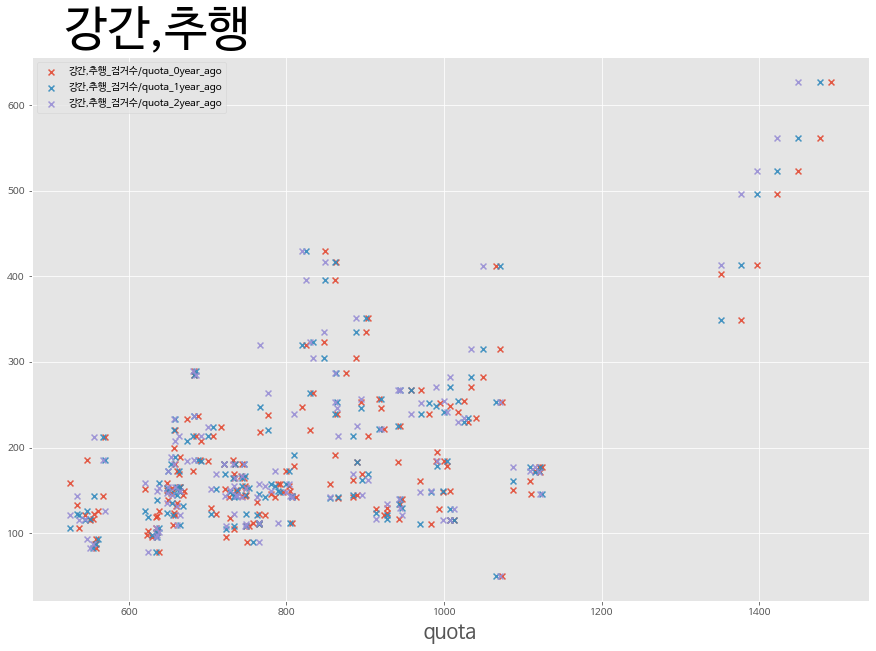

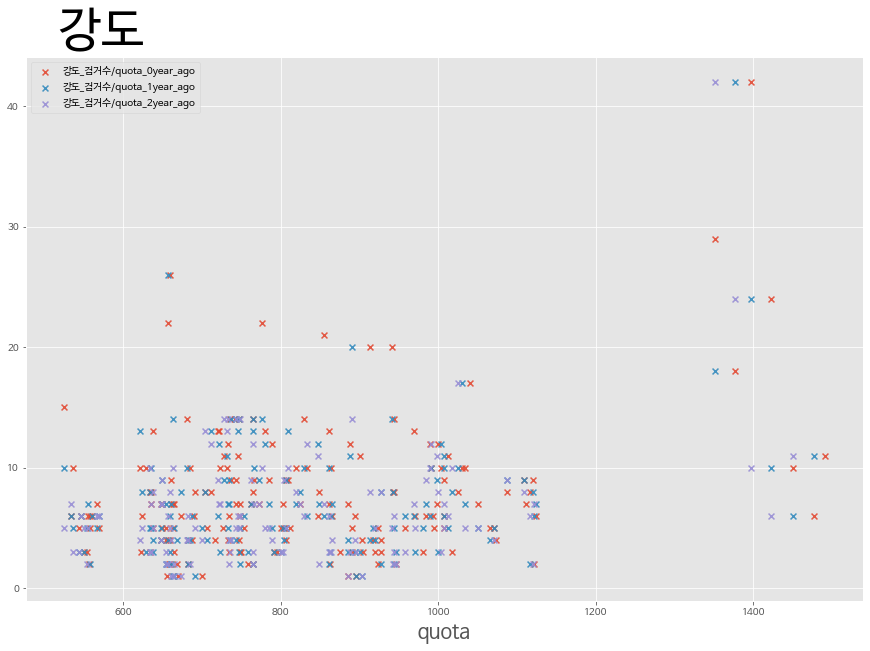

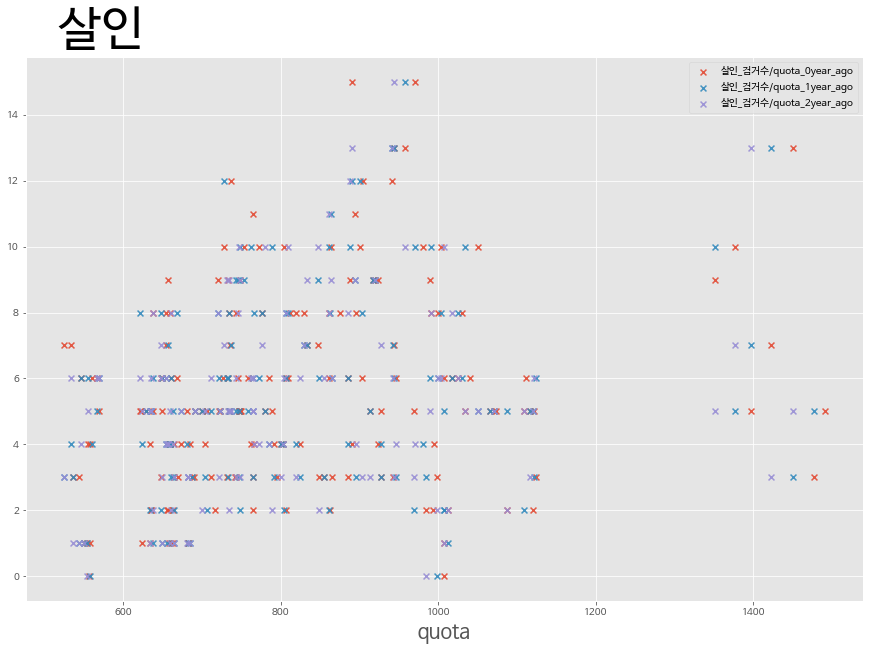

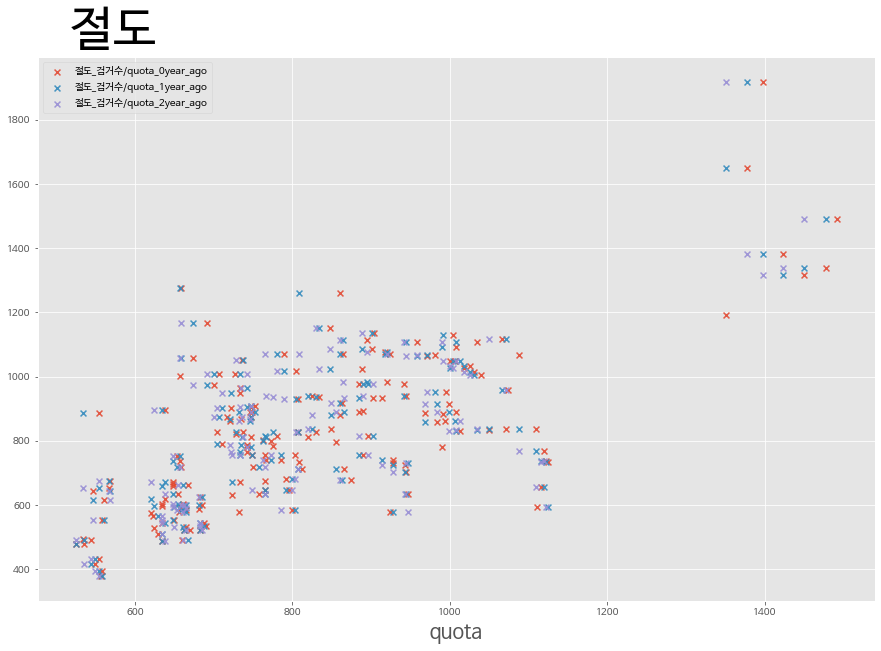

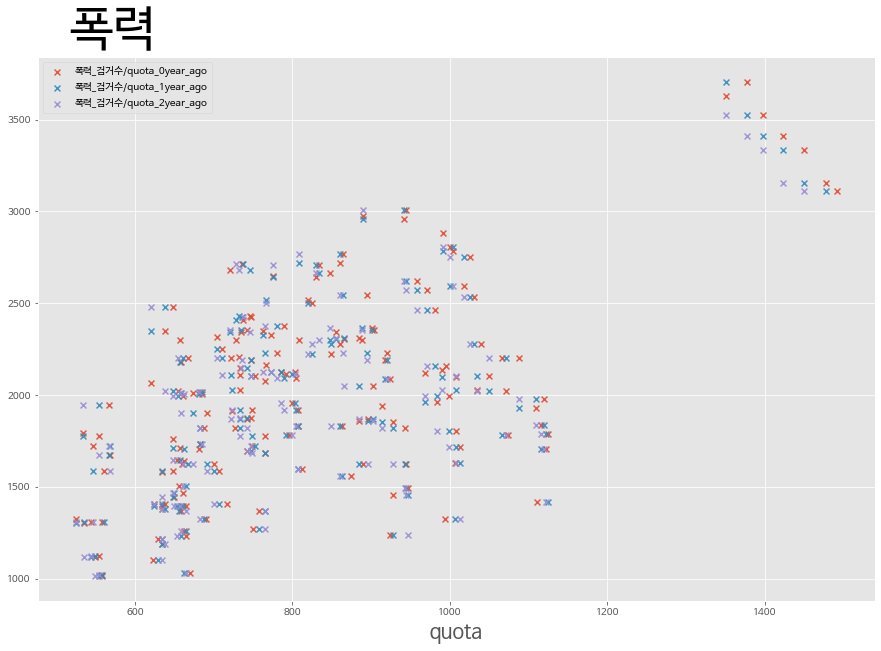

In [75]:
analysis.visualize(x="quota", shift=[0, 1, 2, ], occur=False)

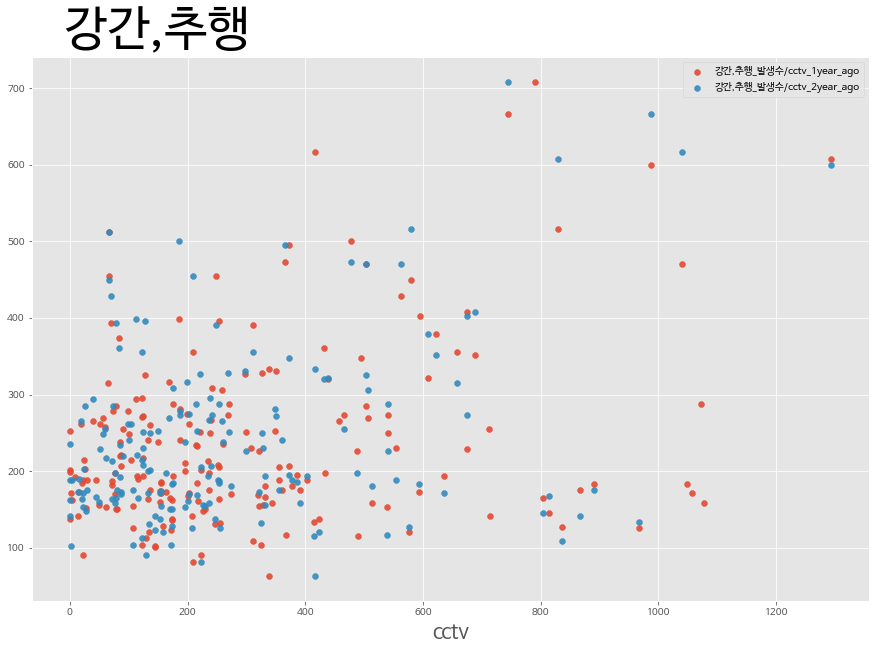

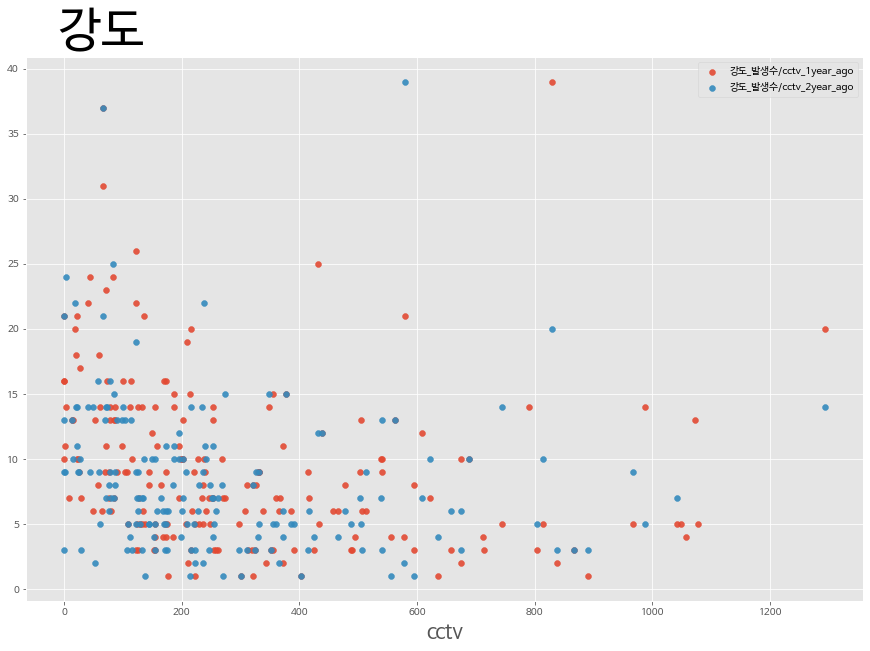

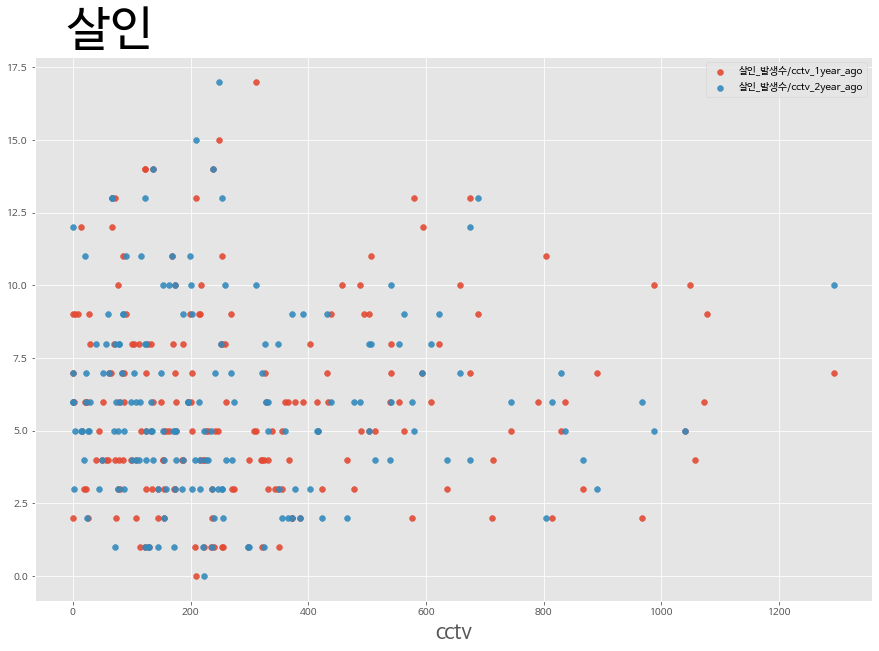

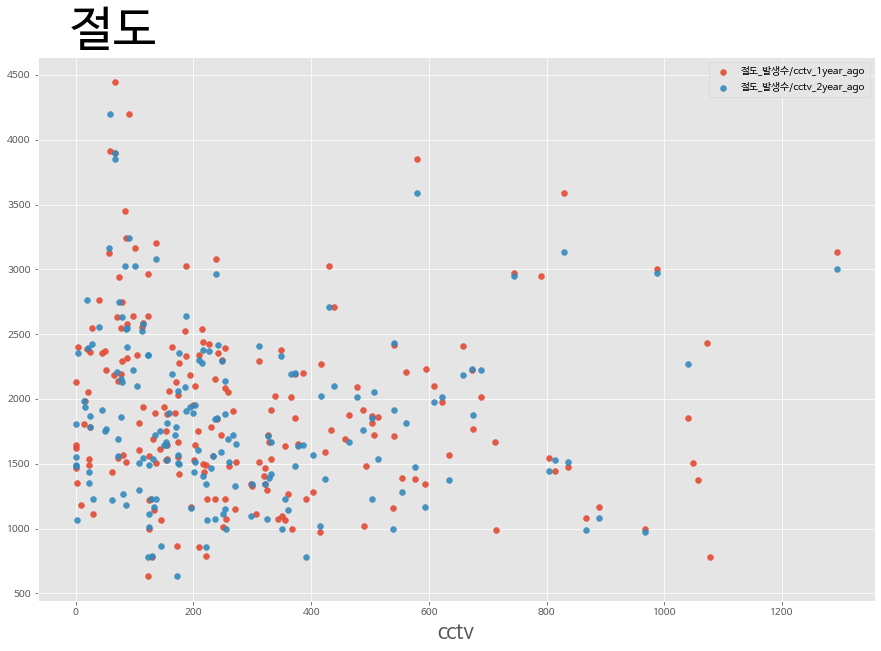

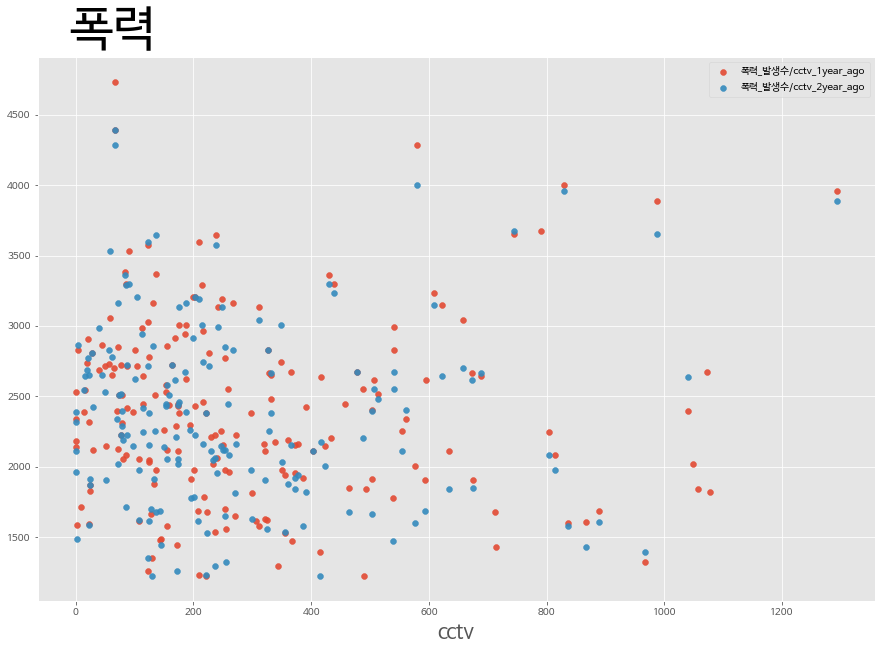

In [78]:
analysis.visualize(x="cctv", shift=[1,2], arrest=False)